# Preliminary operations

We import the libraries and extract the zip file into the Colab environment.

In [3]:
# Utility
# from google.colab import drive
from shutil import copyfile, copy
import matplotlib.pyplot as plt
import IPython.display as ipd
import os
import pandas as pd
import numpy as np
import itertools

# Audio processing
import librosa
import librosa.display
import audiomentations

# Sklearn
from sklearn.metrics import classification_report, confusion_matrix, top_k_accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
import joblib

# Keras
import keras
from keras import regularizers
from keras.regularizers import l2
from keras.models import Sequential, Model
from keras.layers import Input, Dropout, Dense, Activation, Conv2D, MaxPooling2D, GlobalMaxPooling2D
from keras.optimizers import Adam
from keras.utils import np_utils, to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint

## Uncomment the folowing for get audio files from video

In [6]:
# import os
# from moviepy.editor import VideoFileClip

# data_folder = 'data/'
# output_folder = 'output/'

# # Create output folders for each actor
# for actor_num in range(1, 25):
#     actor_folder = os.path.join(output_folder, f'Actor_{actor_num}')
#     os.makedirs(actor_folder, exist_ok=True)

# # Iterate over each actor folder
# for actor_num in range(1, 25):
#     actor_folder = os.path.join(data_folder, f'Actor_{actor_num:02}')  # Modified line

#     # Keep track of the number of processed videos
#     count = 0

#     # Check if the actor folder exists
#     if not os.path.exists(actor_folder):
#         print(f'Actor folder not found: {actor_folder}')
#         continue

#     # Iterate over each video file in the actor folder
#     for filename in os.listdir(actor_folder):
#         if filename.endswith('.mp4'):
#             video_path = os.path.join(actor_folder, filename)

#             # Load the video clip
#             video_clip = VideoFileClip(video_path)

#             # Extract the audio from the video clip
#             audio_clip = video_clip.audio

#             # Save the audio clip as a WAV file in the corresponding actor's output folder
#             output_path = os.path.join(output_folder, f'Actor_{actor_num}', f'{filename[:-4]}.wav')
#             audio_clip.write_audiofile(output_path, codec='pcm_s16le')

#             print(f'Saved audio file: {output_path}')

#             # Increment the count
#             count += 1

#     print(f'Processed videos for Actor_{actor_num:02}: {count}')  # Modified line


# Data exploration

Each filename consists of a 7-part numerical identifier (e.g., 03-01-06-01-02-01-12.wav). These identifiers represent:

*   Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
*   Vocal channel (01 = speech, 02 = song).
*   Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
*   Emotional intensity (01 = normal, 02 = strong (not for neutral emotion)). 
*   Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
*   Repetition (01 = 1st repetition, 02 = 2nd repetition).
*   Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

In [54]:
dir_list = os.listdir('output')
# dir_list.sort()
dir_list

['Actor_1',
 'Actor_10',
 'Actor_11',
 'Actor_12',
 'Actor_13',
 'Actor_14',
 'Actor_15',
 'Actor_16',
 'Actor_17',
 'Actor_18',
 'Actor_19',
 'Actor_2',
 'Actor_20',
 'Actor_21',
 'Actor_22',
 'Actor_23',
 'Actor_24',
 'Actor_3',
 'Actor_4',
 'Actor_5',
 'Actor_6',
 'Actor_7',
 'Actor_8',
 'Actor_9']

In [55]:
count = [0] * 24
j = 0
for i in dir_list:
  filename = os.listdir('output/' + i)
  for f in filename:
    if f.endswith('wav'): 
      count[j]+=1
  j+=1

In [56]:
count

[120,
 120,
 120,
 120,
 120,
 120,
 120,
 120,
 118,
 116,
 120,
 120,
 120,
 120,
 120,
 120,
 120,
 120,
 120,
 120,
 120,
 120,
 120,
 120]

24 subjects, each with 120 audio files.

Now let's divide the audio files according to their labels. We don't consider the neutral emotion because of two reasons: it has half the data then the other emotions and it's very similar to the calm emotion. We have found that the network cannot distinguish neutral class.

In [57]:
def switch(emotion):
  if emotion == 2:
    return 'calm'
  elif emotion == 3:
    return 'happy'
  elif emotion == 4:
    return 'sad'
  elif emotion == 5:
    return 'angry'
  elif emotion == 6:
    return 'fear'
  elif emotion == 7:
    return 'disgust'
  elif emotion == 8:
    return 'surprise'

In [58]:
emotion = []
path = []
for i in dir_list:
  filename = os.listdir('output/' + i)
  for f in filename:
    # Remove wav extension
    id = f[:-4].split('-')
    if(id[2] != '01'):
      # Dividing according to emotions
      emotion.append(switch(int(id[2])))
      path.append('output/' + i + '/' + f)

In [59]:
df = pd.concat([pd.DataFrame(emotion), pd.DataFrame(path)], axis = 1)
df.columns = ['emotion', 'path']
df['emotion'].value_counts()

emotion
calm        384
happy       384
sad         384
fear        384
surprise    384
angry       383
disgust     383
Name: count, dtype: int64

The dataset is perfectly balanced.

Let's pick some tracks.

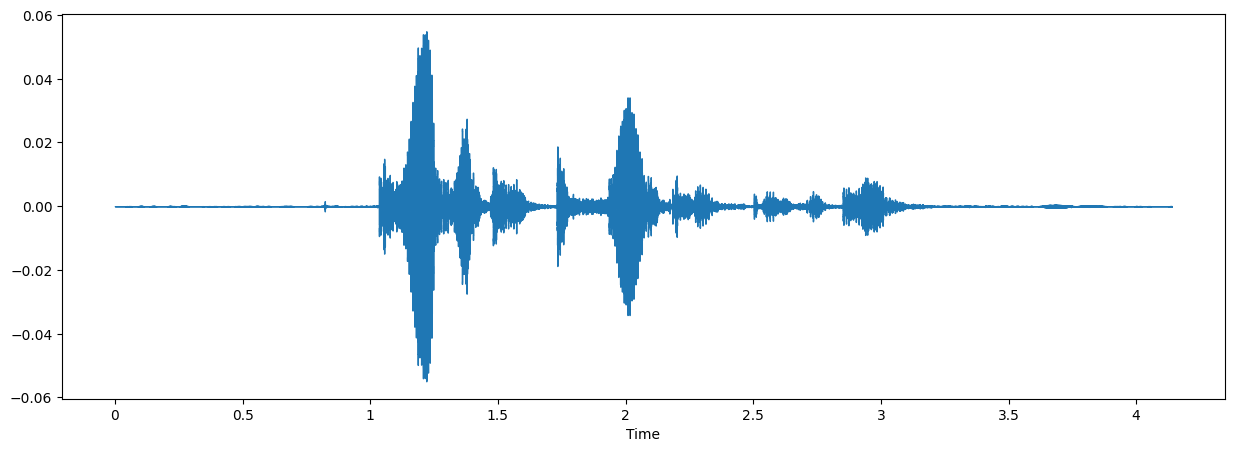

In [60]:
# Disgust - Actor 5
filename = 'output/Actor_5/01-01-07-01-01-02-05.wav'  
data, sampling_rate = librosa.load(filename)

plt.figure(figsize = (15, 5))
librosa.display.waveshow(data, sr = sampling_rate)

ipd.Audio(filename)

We notice some initial noise due to the breath before speaking.

We can already notice a few things:
*   The duration is about 4 seconds.
*   There are some moments of silence at the beginning and at the end. We may remove them by picking just the central seconds.

Now, let's check the duration and the sampling rate for each statement.

In [61]:
duration = []
rate = []
for filename in df['path']:
  data, sampling_rate = librosa.load(filename, sr = 48000) # We want the native sr
  duration.append(data.shape[0])
  rate.append(sampling_rate)
print(np.unique(duration))
print(np.unique(rate))

[143520 144480 146400 147360 149280 151680 152640 154560 155520 157920
 158880 160800 161761 163681 166081 167041 168961 169921 171841 173281
 175201 177121 178081 180001 181441 183361 184321 186241 187201 189601
 191521 192481 194401 195361 197761 198721 200641 202561 204001 205921
 206879 208799 209761 212161 214081 215041 216959 217921 220321 221281
 223201 224161 226081 229441 231361 232321 234721 235681 237601 239521
 242879 246721 254879]
[48000]


The rate is the same for each sample. Let's have a better view of the durations.

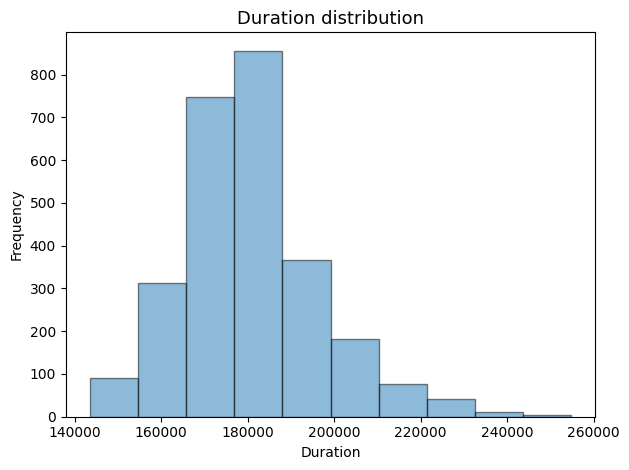

In [62]:
plt.title('Duration distribution', fontsize = 13)
plt.xlabel('Duration')
plt.ylabel('Frequency')
plt.hist(duration, alpha = 0.5, histtype = 'bar', ec = 'black')
plt.tight_layout()
plt.show() 

Duration in seconds = duration / 48000 (sample rate).

In [63]:
print(round(np.mean(duration), 2))
print(np.min(duration))
print(np.max(duration))

180390.07
143520
254879


Seems like we have a mean of ~180000 and a duration span of ~45000.

# Data processing

First of all, we cut the first and the last part of each sample in order to have a uniform duration of 3 seconds. 

In [64]:
audio = []
for filename in df['path']:
  data, sampling_rate = librosa.load(filename, sr = 48000, duration = 3, offset = 0.5) # We want the native sr
  audio.append(data)
df = pd.DataFrame(np.column_stack([df, audio]))
df.columns = ['emotion', 'path', 'data']

c:\Users\aruna\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\shape_base.py:652: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(v)


In [65]:
df.head()

,emotion,path,data
0,calm,output/Actor_1/01-01-02-01-01-01-01.wav,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,calm,output/Actor_1/01-01-02-01-01-02-01.wav,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,calm,output/Actor_1/01-01-02-01-02-01-01.wav,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,calm,output/Actor_1/01-01-02-01-02-02-01.wav,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,calm,output/Actor_1/01-01-02-02-01-01-01.wav,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


We pad with zeros the audio with length < 144000.

In [66]:
for i in range(len(df)):
  if(len(df['data'][i]) != 144000):
    start_pad = (144000 - len(df['data'][i]))//2
    end_pad = 144000 - len(df['data'][i]) - start_pad
    df['data'][i] = np.pad(df['data'][i], (start_pad, end_pad), mode = 'constant')

In [67]:
for i in range(len(df)):
  if(len(df['data'][i]) != 144000):
    print(len(df['data'][i]))

## Feature extraction

We extract the log Mel spectrogram.

Example.

C:\Users\aruna\AppData\Local\Temp\ipykernel_5644\3864085772.py:1: FutureWarning: Pass y=[0. 0. 0. ... 0. 0. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.power_to_db(librosa.feature.melspectrogram(df['data'][1]*1.0, sr = 48000, n_fft = 1024, n_mels = 128, fmin = 50, fmax = 24000))


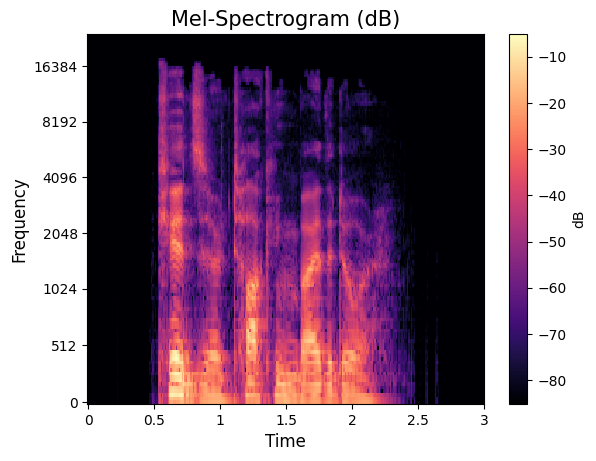

In [68]:
mel = librosa.power_to_db(librosa.feature.melspectrogram(df['data'][1]*1.0, sr = 48000, n_fft = 1024, n_mels = 128, fmin = 50, fmax = 24000)) 
plt.figure()
librosa.display.specshow(mel, sr = 48000, x_axis = 'time', y_axis = 'mel', cmap = 'magma')
plt.colorbar(label = 'dB')
plt.title('Mel-Spectrogram (dB)', fontdict = dict(size = 15))
plt.xlabel('Time', fontdict = dict(size = 12))
plt.ylabel('Frequency', fontdict = dict(size = 12))
plt.show()

In [69]:
def feature_extractor(input, feature, sr = 48000):
  # Mel Spectrogram
  if(feature == 'mel'):
    return librosa.power_to_db(librosa.feature.melspectrogram(input*1.0, sr = sr, n_fft = 1024, n_mels = 128, fmin = 50, fmax = 24000)) 

In [70]:
df['features'] = [0] * 2686
for i in range(len(df)):
  mel = feature_extractor(df['data'][i], 'mel')
  df['features'][i] = np.array(mel, dtype = object)

C:\Users\aruna\AppData\Local\Temp\ipykernel_5644\3622192109.py:4: FutureWarning: Pass y=[0. 0. 0. ... 0. 0. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  return librosa.power_to_db(librosa.feature.melspectrogram(input*1.0, sr = sr, n_fft = 1024, n_mels = 128, fmin = 50, fmax = 24000))
C:\Users\aruna\AppData\Local\Temp\ipykernel_5644\901720756.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['features'][i] = np.array(mel, dtype = object)
C:\Users\aruna\AppData\Local\Temp\ipykernel_5644\3622192109.py:4: FutureWarning: Pass y=[0. 0. 0. ... 0. 0. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  return librosa.power_to_db(librosa.feature.melspectrogram(input*1.0, sr = sr, n_fft = 1024, n_mels

We already split the dataset into training and test, in order to perform augmentation only on the training set. We use actors 21-24 for test.

See i'm not using the full data because i don't have high computatio power and time so change the input if you want

In [ ]:
X_test = df['features'][1120:1344].tolist()
y_test = df['emotion'][1120:1344].tolist()
     

In [ ]:

X_train = df['features'][:1120].tolist()
y_train = df['emotion'][:1120].tolist()

## Data augmentation

This phase is performed in the following way;
1.   We add noise for all the signals.
2.   We pitch all the signals.
3.   We stretch all the signals.
4.   We shift all the signals.

In the end, we'll have the following data:
*   Original dataset.
*   Noise dataset.
*   Pitch dataset.
*   Stretch dataset.
*   Shift dataset.

### Noise

In [ ]:
noise = audiomentations.Compose([
    audiomentations.AddGaussianNoise(p = 1)
])

In [ ]:
for i in range(1120):
  augmented_samples = noise(df['data'][i], 48000)
  mel = feature_extractor(augmented_samples, 'mel')
  X_train.append(np.array(mel, dtype = object))
  y_train.append(df['emotion'][i])

C:\Users\aruna\AppData\Local\Temp\ipykernel_5644\3622192109.py:4: FutureWarning: Pass y=[ 0.00285114  0.00812385 -0.00487579 ...  0.00055606 -0.01139444
 -0.00302591] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  return librosa.power_to_db(librosa.feature.melspectrogram(input*1.0, sr = sr, n_fft = 1024, n_mels = 128, fmin = 50, fmax = 24000))
C:\Users\aruna\AppData\Local\Temp\ipykernel_5644\3622192109.py:4: FutureWarning: Pass y=[-0.00909729  0.00228074 -0.00496307 ... -0.01719563  0.01731056
  0.01469528] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  return librosa.power_to_db(librosa.feature.melspectrogram(input*1.0, sr = sr, n_fft = 1024, n_mels = 128, fmin = 50, fmax = 24000))
C:\Users\aruna\AppData\Local\Temp\ipykernel_5644\3622192109.py:4: FutureWarning: Pass y=[ 0.00075778  0.01877999 -0.00211979 ... -0.00095051  0.00084666
  0.00164866] as keyword args. From version 0.10 pa

### Pitch

In [ ]:
pitchShift = audiomentations.Compose([
    audiomentations.PitchShift(p = 1)
])

In [ ]:
for i in range(1120):
  augmented_samples = pitchShift(df['data'][i], 48000)
  mel = feature_extractor(augmented_samples, 'mel')
  X_train.append(np.array(mel, dtype = object))
  y_train.append(df['emotion'][i])

C:\Users\aruna\AppData\Local\Temp\ipykernel_5644\3622192109.py:4: FutureWarning: Pass y=[0. 0. 0. ... 0. 0. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  return librosa.power_to_db(librosa.feature.melspectrogram(input*1.0, sr = sr, n_fft = 1024, n_mels = 128, fmin = 50, fmax = 24000))
C:\Users\aruna\AppData\Local\Temp\ipykernel_5644\3622192109.py:4: FutureWarning: Pass y=[-1.9504454e-12  4.6823976e-13  1.1943534e-12 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  return librosa.power_to_db(librosa.feature.melspectrogram(input*1.0, sr = sr, n_fft = 1024, n_mels = 128, fmin = 50, fmax = 24000))
C:\Users\aruna\AppData\Local\Temp\ipykernel_5644\3622192109.py:4: FutureWarning: Pass y=[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 2.3055520e-08 2.7893375e-07
 1.1175162e-07] as keyword args. From version 0.10 passing these as positional

### Stretch

In [ ]:
stretch = audiomentations.Compose([
    audiomentations.TimeStretch(p = 1)
])

In [ ]:
for i in range(1120):
  augmented_samples = stretch(df['data'][i], 48000)
  mel = feature_extractor(augmented_samples, 'mel')
  X_train.append(np.array(mel, dtype = object))
  y_train.append(df['emotion'][i])

C:\Users\aruna\AppData\Local\Temp\ipykernel_5644\3622192109.py:4: FutureWarning: Pass y=[0. 0. 0. ... 0. 0. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  return librosa.power_to_db(librosa.feature.melspectrogram(input*1.0, sr = sr, n_fft = 1024, n_mels = 128, fmin = 50, fmax = 24000))
C:\Users\aruna\AppData\Local\Temp\ipykernel_5644\3622192109.py:4: FutureWarning: Pass y=[-1.4354750e-12 -1.0772117e-12  2.9708718e-12 ...  2.5144609e-06
  4.3925643e-06  3.7266736e-06] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  return librosa.power_to_db(librosa.feature.melspectrogram(input*1.0, sr = sr, n_fft = 1024, n_mels = 128, fmin = 50, fmax = 24000))
C:\Users\aruna\AppData\Local\Temp\ipykernel_5644\3622192109.py:4: FutureWarning: Pass y=[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -3.1499021e-05
 -2.7815433e-05 -2.4710864e-05] as keyword args. From version 0.10 passing these as posi

### Shift

In [ ]:
shift = audiomentations.Compose([
    audiomentations.Shift(min_fraction = 0.25, max_fraction = 0.25, rollover = False, p = 1)
])

In [ ]:
for i in range(1120):  
  augmented_samples = shift(df['data'][i], 48000)
  mel = feature_extractor(augmented_samples, 'mel')
  X_train.append(np.array(mel, dtype = object))
  y_train.append(df['emotion'][i])

C:\Users\aruna\AppData\Local\Temp\ipykernel_5644\3622192109.py:4: FutureWarning: Pass y=[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.4314144e-06
  2.8400632e-07  6.4264412e-07] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  return librosa.power_to_db(librosa.feature.melspectrogram(input*1.0, sr = sr, n_fft = 1024, n_mels = 128, fmin = 50, fmax = 24000))
C:\Users\aruna\AppData\Local\Temp\ipykernel_5644\3622192109.py:4: FutureWarning: Pass y=[0.         0.         0.         ... 0.00026815 0.0002358  0.00021614] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  return librosa.power_to_db(librosa.feature.melspectrogram(input*1.0, sr = sr, n_fft = 1024, n_mels = 128, fmin = 50, fmax = 24000))
C:\Users\aruna\AppData\Local\Temp\ipykernel_5644\3622192109.py:4: FutureWarning: Pass y=[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 6.0871139e-06 3.4008626e-05
 2.8751982e-05] as keyword arg

In [ ]:
print('We obtained ' + str(len(X_train)) + ' samples.')

We obtained 8286 samples.


## Split train-test

We load and normalize the data.

In [ ]:
for i in range(len(X_train)):
  X_train[i] = X_train[i].astype(np.float64)
for i in range(len(X_test)):
  X_test[i] = X_test[i].astype(np.float64)

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

scaler_train = StandardScaler()

X_train[:1120] = scaler_train.fit_transform(X_train[:1120].reshape(-1, X_train.shape[-1])).reshape(X_train[:1120].shape)
X_train[1120:] = scaler_train.transform(X_train[1120:].reshape(-1, X_train.shape[-1])).reshape(X_train[1120:].shape)
X_test = scaler_train.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

Saving scaler for demo purpose.

In [ ]:
joblib.dump(scaler_train, 'Digital_signal/Dataset/std_scaler.bin')

['Digital_signal/Dataset/std_scaler.bin']

In [ ]:
# One-hot encode the target 
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

In [ ]:
# Making data compatible for the model
X_train = np.expand_dims(X_train, axis = 3)
X_test = np.expand_dims(X_test, axis = 3)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((8286, 128, 282, 1), (8286, 7), (224, 128, 282, 1), (224, 7))

Saving test data for demo purpose.

In [43]:
np.save('Digital_signal/Dataset/X_test', X_test)
np.save('Digital_signal/Dataset/y_test', y_test)

In [ ]:
df = 0

# Model selection

####  Rectangular kernel

We change the kernel size to a rectangular shape, due to the rectangular shape of the mel spectrograms.

In [ ]:
X_val = X_train[896:1120]
y_val = y_train[896:1120]
# We don't have to pick the validation data augmented
to_remove = list(range(896, 1120)) + list(range(2016, 2240)) + list(range(3136, 3360)) + list(range(4256, 4480)) + list(range(5376, 5600)) 
X_train = np.delete(X_train, to_remove, axis = 0)
y_train = np.delete(y_train, to_remove, axis = 0)
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((7166, 128, 282, 1),
 (7166, 7),
 (224, 128, 282, 1),
 (224, 7),
 (224, 128, 282, 1),
 (224, 7))

In [ ]:
num_classes = 7

model32 = Sequential()

model32.add(Conv2D(64, (3, 5), activation = 'relu', input_shape = (128, 282, 1)))
model32.add(MaxPooling2D((2, 2)))

model32.add(Conv2D(128, (3, 5), activation = 'relu', kernel_regularizer = l2(0.001), bias_regularizer = l2(0.01)))
model32.add(MaxPooling2D((2, 2)))
model32.add(Dropout(0.2))

model32.add(Conv2D(128, (3, 5), activation = 'relu', kernel_regularizer = l2(0.001), bias_regularizer = l2(0.01)))
model32.add(GlobalMaxPooling2D())
model32.add(Dropout(0.2))

model32.add(Dense(128, activation = 'relu', kernel_regularizer = l2(0.001), bias_regularizer = l2(0.01)))
model32.add(Dropout(0.2))

model32.add(Dense(num_classes, activation = 'softmax'))

model32.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 278, 64)      1024      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 139, 64)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 135, 128)      123008    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 67, 128)      0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 30, 67, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 63, 128)       2

In [ ]:
stop_early = EarlyStopping(monitor = 'val_loss', patience = 20, restore_best_weights = True)

In [ ]:
model32.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate = 0.001), metrics = ['accuracy'])
history32 = model32.fit(X_train, y_train, batch_size = 32, epochs = 5, validation_data = (X_val, y_val), callbacks = [stop_early])

Epoch 1/10
224/224 [==============================] - 704s 3s/step - loss: 2.0130 - accuracy: 0.1807 - val_loss: 1.9313 - val_accuracy: 0.2232
Epoch 2/10
224/224 [==============================] - 698s 3s/step - loss: 1.9113 - accuracy: 0.2043 - val_loss: 1.8792 - val_accuracy: 0.2188
Epoch 3/10
224/224 [==============================] - 737s 3s/step - loss: 1.8935 - accuracy: 0.2124 - val_loss: 1.8652 - val_accuracy: 0.2188
Epoch 4/10
224/224 [==============================] - 700s 3s/step - loss: 1.8768 - accuracy: 0.2143 - val_loss: 1.8446 - val_accuracy: 0.2500
Epoch 5/10
224/224 [==============================] - 662s 3s/step - loss: 1.8663 - accuracy: 0.2224 - val_loss: 1.8518 - val_accuracy: 0.2411
Epoch 6/10
224/224 [==============================] - 707s 3s/step - loss: 1.8573 - accuracy: 0.2167 - val_loss: 1.8639 - val_accuracy: 0.2188
Epoch 7/10
224/224 [==============================] - 674s 3s/step - loss: 1.8551 - accuracy: 0.2217 - val_loss: 1.8236 - val_accuracy: 0.2634

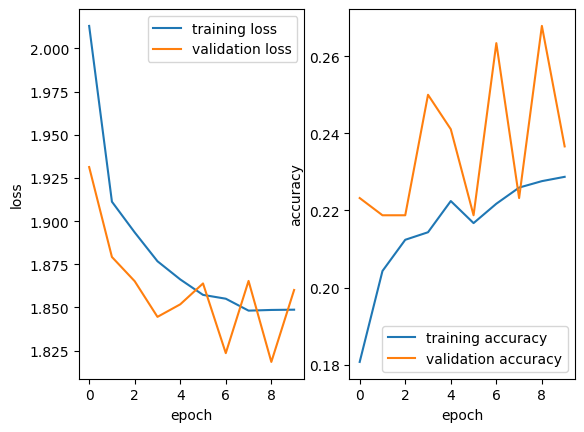

In [ ]:
plt.subplot(1,2,1)
plt.plot(history32.history['loss'])
plt.plot(history32.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training loss', 'validation loss'])

plt.subplot(1,2,2)
plt.plot(history32.history['accuracy'])
plt.plot(history32.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['training accuracy', 'validation accuracy'])

In [ ]:
y_pred = model32.predict(X_val)
y_pred_ = np.argmax(y_pred, axis = 1)
y_val_ = np.argmax(y_val, axis = 1)
print(classification_report(y_val_, y_pred_))

7/7 [==============================] - 6s 777ms/step
              precision    recall  f1-score   support

           0       0.21      0.35      0.26        31
           1       0.75      0.35      0.48        34
           2       0.73      0.26      0.38        31
           3       0.12      0.03      0.05        32
           4       0.08      0.03      0.04        32
           5       0.43      0.09      0.15        32
           6       0.15      0.53      0.23        32

    accuracy                           0.24       224
   macro avg       0.35      0.24      0.23       224
weighted avg       0.35      0.24      0.23       224



Mapping:
0. Angry.
1. Calm.
2. Disgust.
3. Fear.
4. Happy.
5. Sad.
6. Surprise.

Text(0, 0.5, 'Prediction')

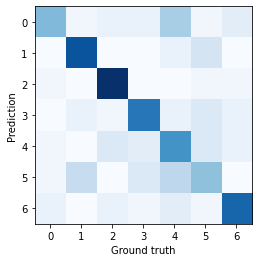

In [ ]:
cm = confusion_matrix(y_val_, y_pred_)
plt.imshow(cm, cmap = plt.cm.Blues)
plt.xlabel('Ground truth')
plt.ylabel('Prediction')

In [ ]:
print(top_k_accuracy_score(y_val_, y_pred, k = 2))
print(top_k_accuracy_score(y_val_, y_pred, k = 3))

0.39732142857142855
0.5669642857142857


# Saving

Now we may merge training set and validation set in order to re-train all of our models on a bigger set of data. Then, we'll test the performances on the test set.

In [ ]:
model32.save('Models/Audio_steam/model3_2.h5')